# Wasserstein Generative Adversarial Networks

#### *Nicolas Courty, Rémi Flamary*

In this tutorial, we will see how to use the Wasserstein distance in the process of learning a Generative Adversarial Network (GAN). GAN are powerful objects that provide means of generating new samples from complex, high-dimensional distributions $P_r$ (such as collection of images) by learning a generative network $g_\theta$, parametrized by $\theta$, that takes a low-dimensional noise (let's say $d$ dimensional) as input. As such, $P_\theta = g_\theta(Z)$, $Z \sim \mathcal{N}({\bf 0}_d, {\bf I}_{d\times d})$ should match as close as possible $P_r$.

There exists several ways to train this generator. In a nutshell, the basic idea is to align the distribution of generated samples to the distribution that we want to match.

In a seminal work, Goodfellow [1] proposed to learn a generator that produces samples that are undistinguishable from the input distribution sample up to a classifier that tries to distinguish them. This leads to an adversarial approach , where both the generator and the classifier work in competition.

Another class of approach considers minimizing a divergence $\delta$ between $P_r$ and $P_\theta$ as a loss function for training $g_\theta$. Several options exist for $\delta$, for example:
* Total Variation, $\delta(P_r,P_\theta) = \sup_{A} | P_r(A) - P_\theta(A) |$
* Kullback-Leibler (KL) divergence, $\delta(P_r,P_\theta) = KL(P_r\|P_\theta) = \int_x \log\left(\frac{P_r(x)}{P_\theta(x)}\right) P_r(x) \,dx$

Arjovsky and colleagues [2] proposed to use the Wasserstein 1 distance in this context. We have here:
$$ \delta(P_r,P_\theta) = W_1(P_r,P_\theta) = \inf_{\gamma \in \Pi(P_r ,P_\theta)} \mathbb{E}_{(x, y) \sim \gamma}\big[\:\|x - y\|\:\big] $$

There are several nice properties associated with this:
* the resulting model is very easy to implement and simple;
* the gradients of $W_1$ are practically never 0, which can be the case with Total Variation or KL divergence, especially when the supports of $P_r$ and $P_\theta$ do not overlap.

However, computing $W_1$ requires to compute a coupling $\gamma$ which is infeasible for large datasets. Instead, relying on the Kantorovich-Rubinstein duality, one can instead consider the dual formulation of $W_1$:
$$W(P_r, P_\theta) = \sup_{\|f\|_L \leq 1} \mathbb{E}_{x \sim P_r}[f(x)] - \mathbb{E}_{x \sim P_\theta}[f(x)]$$
where the supremum is taken over all $1-$Lipschitz functions.

We are going to explore, how in a task of generating a simple 2D toy distribution, how to implement such a generative adversarial network. 

#### Ref. 
[1] Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. 2014. Generative adversarial nets. In Proceedings of the 27th International Conference on Neural Information Processing Systems - Volume 2 (NIPS'14), Vol. 2. MIT Press, Cambridge, MA, USA, 2672-2680. 

[2]  Martin Arjovsky, Soumith Chintala, Léon Bottou. 2017, Wasserstein Generative Adversarial Networks. Proceedings of the 34th International Conference on Machine Learning, PMLR 70:214-223, 2017

The paper can be found here http://proceedings.mlr.press/v70/arjovsky17a/arjovsky17a.pdf

####  Generating the data

We starting by generating a simple circle-like 2D distributions that we will try to approximate through our GAN.

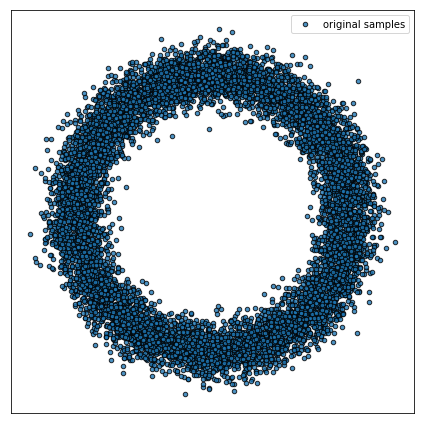

In [54]:
import numpy as np
import pylab as pl


nb_samples = 10000

radius = 1 

nz =.1

# generate the data
X_train = np.zeros((nb_samples,2))
r = np.random.normal(radius,nz,nb_samples)
theta=np.random.rand(nb_samples)*2*np.pi
X_train[:,0]=r*np.cos(theta)
X_train[:,1]=r*np.sin(theta)



pl.figure(figsize=(6,6))
pl.scatter(X_train[:,0], X_train[:,1],s = 20, alpha=0.8, edgecolor = 'k', marker = 'o',label='original samples') 
pl.xticks([], [])
pl.yticks([], [])
pl.legend(loc='best')
pl.tight_layout()
pl.show()


#### A Keras implementation of WGAN

In order to implement our GAN model, we will use the Keras toolbox, with Theano or Tensorflow as backend. If it is not installed on your machine, please install it. 

In [55]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.layers import Activation

from keras.optimizers import Adam
from keras import backend as K

We will start by creating our generator $g_\theta(Z)$. It consists in a neural network that will take a $d-$dimensional noise vector and produce a sample in 2D.

I suggest the following 2-layers architecture, where the non-linearity is produced by using the ReLu activation. The final layer has Linear activations, so that the 2D coordinates can be arbitrarly positive or/and negative.

In [56]:
def make_generator(noise_dim=100):
    model = Sequential()
    model.add(Dense(128,  kernel_initializer='he_normal', input_dim=noise_dim))
    model.add(Activation('relu'))      
    model.add(Dense(64,  kernel_initializer='he_normal'))
    model.add(Activation('relu'))      
    model.add(Dense(units=2, activation='linear'))
    return model

The second step is a network, usually called *discriminator* in the literature, that is the dual function $f()$ in the previous definition (Kantorovich potential). This function, as a potential function, outputs a scalar value.

Please note that this is where the first approximation comes into play. Because $f()$ belongs to a particular class of parametrized neural network, we are not any more optimizing over the set of all $1-$Lipschitz functions.

In [57]:
def make_discriminator():
    model = Sequential()
    model.add(Dense(128, kernel_initializer='he_normal', input_dim=2))
    model.add(Activation('relu'))      
    model.add(Dense(64, kernel_initializer='he_normal', input_dim=2))
    model.add(Activation('relu'))      
    model.add(Dense(units=1, activation='linear'))
    return model

Now we have both our generator and discriminator. We will construct two of them. We will use a noise dimension of 2.

In [58]:
noise_dim=2

generator = make_generator(noise_dim)
discriminator = make_discriminator()

We recall here that we want to miminize the Wasserstein distance between the nominal distribution $P_r$ and the generated distribution $P_\theta$. This leads to the following optimization problem:
$$ \min_\theta W_1(P_r,P_\theta) = \min_\theta \sup_{f, ||f||_L=1} \mathbb{E}_{x \sim P_r}[f(x)] - \mathbb{E}_{z \sim \mathcal{N}}[f(g_\theta(z))]$$
In order to find $g_\theta()$, this bi-level optimization problem has to be solved. Generally, one first optimizes over $f()$ with a fixed generator, and, after fixing $f()$, simply maximizes   $\mathbb{E}_{z \sim \mathcal{N}}[f(g_\theta(z))]$ by backpropagating the gradient of $f()$ in $g_\theta$.

We will first express the two expectations as a simple loss function that simply computes the expectations of $f()$ over $P_r$ and over $P_\theta$.
In order to take into account the plus and minus signs inside, we simply use a scalar product with a vector of ones or minus ones.
Write this corresponding loss function. 


In [7]:
def wasserstein_loss(y_true, y_pred):
    return # TO BE FILLED

We now express the fact that when one optimizes over $f()$, $g_\theta$ is fixed and vice-versa. The discriminator weights are frozen:

In [29]:
for layer in discriminator.layers:
    layer.trainable = False
discriminator.trainable = False

And we connect the generator and the discrimnator together to get the full generator model that will be optimized.

In [30]:
generator_input = Input(shape=(noise_dim,))
generator_layers = generator(generator_input)
discriminator_layers_for_generator = discriminator(generator_layers)
generator_model = Model(inputs=[generator_input], outputs=[discriminator_layers_for_generator])

We compile it, together with the Adam optimizer as used in the original papers.

In [31]:
generator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_loss)


Now we can express the total discriminator model by freezing the generator layers:

In [11]:
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False

real_samples = Input(shape=X_train.shape[1:])
generator_input_for_discriminator = Input(shape=(noise_dim,))
generated_samples_for_discriminator = generator(generator_input_for_discriminator)
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)

Note how the model output values for both real and generated samples.

In [12]:
discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator],
                            outputs=[discriminator_output_from_real_samples,
                                     discriminator_output_from_generator])

And we finally compile it with the two expectation losses:

In [13]:
discriminator_model.compile(optimizer=Adam(0.001, beta_1=0.5, beta_2=0.9),
                            loss=[wasserstein_loss,wasserstein_loss])

#### Lipschitz constant and neural networks


If we replace the supremum over $1-$Lipschitz functions
with the supremum over $K-$Lipschitz functions, then the supremum is $K \cdot W(P_r, P_\theta)$ instead (This is true because every $K-$Lipschitz
function is a $1-$Lipschitz function if you divide it by $K$, and the Wasserstein objective is linear).

The supremum over $K-$Lipschitz functions $\{f : \|f\|_L \le K\}$ is still intractable, but now it’s easier to approximate.
Suppose we have a parametrized function family $\{f_w\}_{w \in \mathcal{W}}$,
where $w$ are the weights and $\mathcal{W}$ is the set of all possible weights. Further suppose these functions are all
$K-$Lipschitz for some $K$. Then we have

$$\begin{aligned}
    \max_{w \in \mathcal{W}}
        \mathbb{E}_{x \sim P_r}[f_w(x)] - \mathbb{E}_{x \sim P_\theta}[f_w(x)]
    &\le \sup_{\|f\|_L \le K}
        \mathbb{E}_{x \sim P_r}[f(x)] - \mathbb{E}_{x \sim P_\theta}[f(x)] \\
    &= K \cdot W(P_r, P_\theta)
\end{aligned}$$

Actually we only care about the gradients of $ W(P_r, P_\theta)$, so adding multiplying it by a constant $K$ does not change anything. To guarantee that 
$f_w$ is $K-$Lipschitz, the original WGAN paper proposes to use weight clipping. The weights $w$ are constrained to lie within $[-c, c]$,
by clipping $w$ after every update to $w$. 

Write a function that actually performs this clipping.

In [14]:
def discriminator_clip(f,c):
    # TO BE FILLED

#### Running the full model

Before running the full model, we provide a function that will help in visualizing the generated samples

In [15]:
def generate_images(generator_model,noise_dim, num_samples=1000):
    predicted_samples = generator_model.predict(np.random.rand(num_samples, noise_dim))
    pl.figure(figsize=(6,6))
    pl.scatter(X_train[:,0], X_train[:,1],s = 40, alpha=0.2, edgecolor = 'k', marker = '+',label='original samples') 
    pl.scatter(predicted_samples[:,0], predicted_samples[:,1],s = 10, alpha=0.9,c='r', edgecolor = 'k', marker = 'o',label='predicted') 
    pl.xticks([], [])
    pl.yticks([], [])
    pl.legend(loc='best')
    pl.tight_layout()    
    pl.show()
    


It is now time to run the full model. In theory, one should wait for the full convergence of $f$ before updating $g_\theta$, but in practice it can be done after a few iterations over $f$ (another layer of approximation here !). We therefore define a training ratio, which basically states the number of discriminator updates per generator update.


In [16]:
BATCH_SIZE = 128
TRAINING_RATIO = 5  

Now we will write the final loop


('Epoch: ', 0)


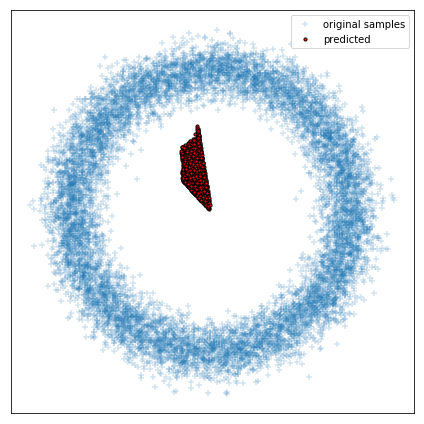

('Epoch: ', 50)


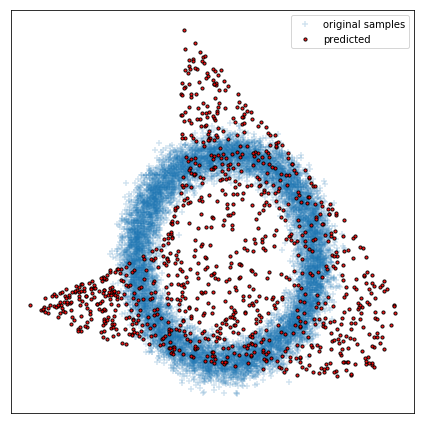

('Epoch: ', 100)


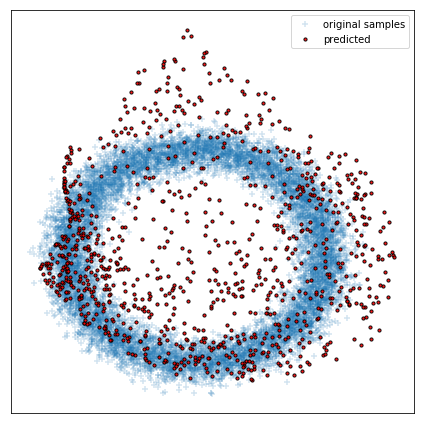

('Epoch: ', 150)


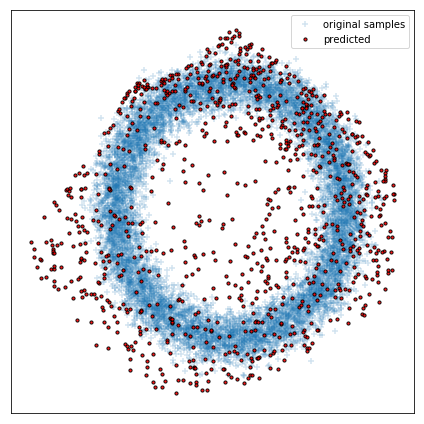

('Epoch: ', 200)


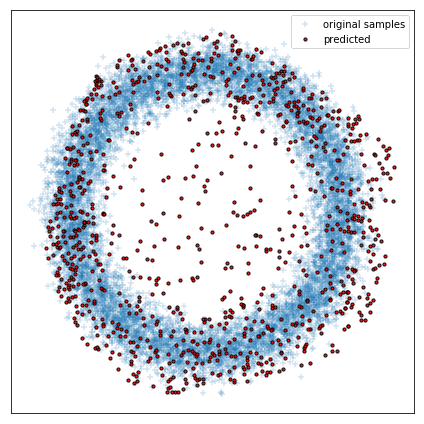

('Epoch: ', 250)


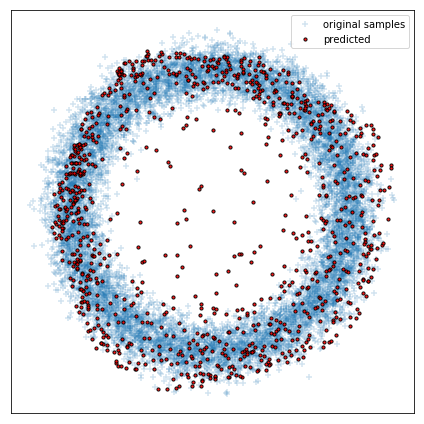

('Epoch: ', 300)


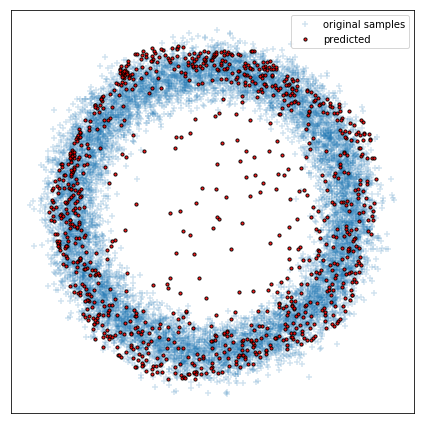

('Epoch: ', 350)


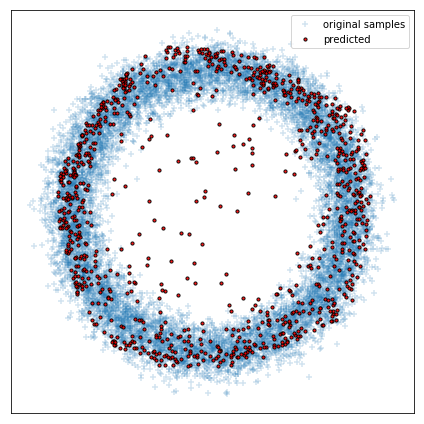

('Epoch: ', 400)


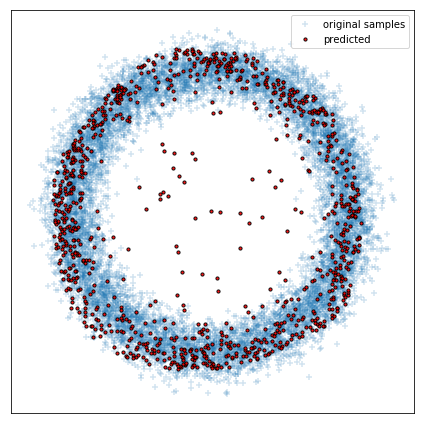

('Epoch: ', 450)


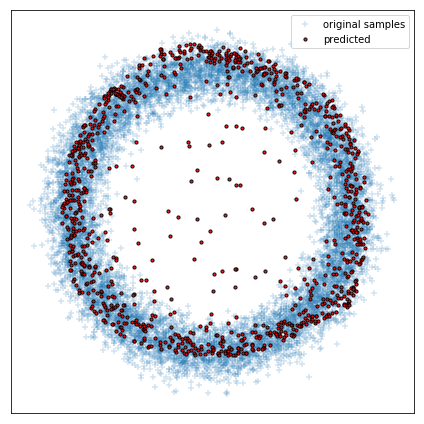

In [17]:
positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y

for epoch in range(500):
    np.random.shuffle(X_train)

    minibatches_size = BATCH_SIZE * TRAINING_RATIO
    
    for i in range(int(X_train.shape[0] // (BATCH_SIZE * TRAINING_RATIO))):
        discriminator_minibatches = X_train[i * minibatches_size:(i + 1) * minibatches_size]
        for j in range(TRAINING_RATIO):
            discriminator_clip(discriminator_model,0.3) # 0.3 is a good value for our toy example
            sample_batch = discriminator_minibatches[j * BATCH_SIZE:(j + 1) * BATCH_SIZE]
            
            # we sample the noise
            noise = # TO BE FILLED
            
            # and we train on batches the discrimnator
            discriminator_model.train_on_batch(# TO BE FILLED)
        
        # then we train the generator after TRAINING_RATIO updates
        generator_model.train_on_batch(# TO BE FILLED)
        
    #Visualization of intermediate results
    if epoch%50==0:
        print("Epoch: ", epoch)
        generate_images(generator, noise_dim)

You can play with the different parameters of the code to see how making this GAN converge is nonetheless a fragile thing. 

## Gradient penalty

Achieving the $K-$Lipschitz condition with weight clipping is a trick that might suffer from some drawbacks, such as poor convergence or poor quality of generated samples, mostly because of underuse of the capacity of the network. In [3], Gulrajani and colleagues proposed a different way of achieving the Lipschitz constraint of $f$ by constraining the norm of the gradient of $f$ to be $1$. The corresponding approximation then reads:

$$ \min_\theta W_1(P_r,P_\theta) \approx \min_\theta \max_w \mathbb{E}_{x \sim P_r}[f_w(x)] - \mathbb{E}_{z \sim \mathcal{N}}[f_w(g_\theta(z))] + \lambda \mathbb{E}_{\hat{x} \sim P_\hat{x}}[||\nabla_\hat{x} f(\hat{x})||_2 - 1)^2], $$

where $ P_\hat{x} $ is defined implicitly by sampling uniformly along straight lines between
pairs of points sampled from the data distribution $P_r$ and and the generator distribution
$P_\theta$. Practically, this means that we will have to:
* construct weighted averages between 
  $x_1 \sim P_r$ and $x_2 \sim P_\theta$ such that $\hat{x} = (1-\epsilon)x_1 + \epsilon x_2$ with
  $\epsilon \sim \mathcal{U}(0,1)$;
* evaluate the gradient of $f$ on those points;
* define a new loss that constraint this gradient to be close to $1$ when learning for $f$.


[3] Gulrajani, Ishaan & Ahmed, Faruk & Arjovsky, Martin & Dumoulin, Vincent & Courville, Aaron. (2017). Improved Training of Wasserstein GANs. 
https://arxiv.org/pdf/1704.00028.pdf

#### Gradient penalty loss function


Write the gradient penalty loss function, that takes as parameters a batch of points $\hat{x}$, and the $\lambda$ parametrizing the strength of this regularization 

In [59]:
def gradient_penalty_loss(y_true, y_pred, averaged_samples, lamba_reg):
    return # TO BE FILLED

The interpolation between samples will be realized by a specific keras (merge) layer:


In [60]:
from keras.layers.merge import _Merge

class RandomWeightedAverage(_Merge):
    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

The discriminator network is now a little bit more complicated since it needs to output its value for the generated samples.

In [65]:
# We start by building new models

generator = make_generator(noise_dim)
discriminator = make_discriminator()

#### for the generator it is mostly the same as before

for layer in discriminator.layers:
    layer.trainable = False
discriminator.trainable = False

generator_input = Input(shape=(noise_dim,))
generator_layers = generator(generator_input)
discriminator_layers_for_generator = discriminator(generator_layers)
generator_model = Model(inputs=[generator_input], outputs=[discriminator_layers_for_generator])

generator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_loss)

#### New discriminator model 

for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False

real_samples = Input(shape=X_train.shape[1:])
generator_input_for_discriminator = Input(shape=(noise_dim,))
generated_samples_for_discriminator = generator(generator_input_for_discriminator)
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)

averaged_samples = RandomWeightedAverage()([real_samples, generated_samples_for_discriminator])
averaged_samples_out = discriminator(averaged_samples)

discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator],
                            outputs=[discriminator_output_from_real_samples,
                                     discriminator_output_from_generator,
                                     averaged_samples_out])

    

the loss function takes more inputs than the standard y_true and y_pred values usually required for a loss function. We will make it a partial.


In [62]:
from functools import partial

GRADIENT_PENALTY_WEIGHT = 1

partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=averaged_samples,
                          lamba_reg=GRADIENT_PENALTY_WEIGHT)
partial_gp_loss.__name__ = 'gp_loss' 

And we are now ready to compile the model

In [63]:
discriminator_model.compile(optimizer=Adam(0.001, beta_1=0.5, beta_2=0.9),
                            loss=[wasserstein_loss,
                                  wasserstein_loss,
                                  partial_gp_loss])

### final loop 

('Epoch: ', 0)


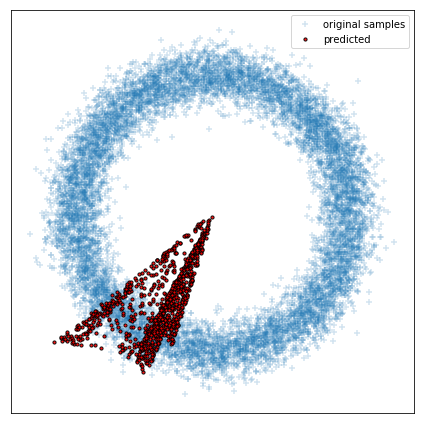

('Epoch: ', 50)


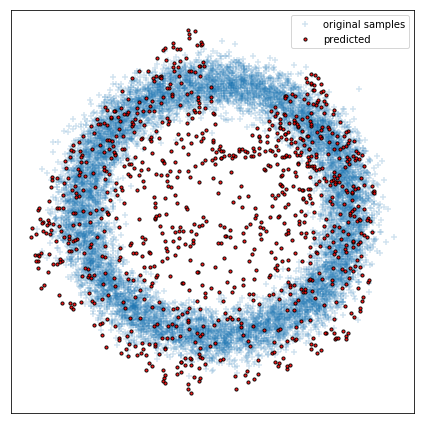

('Epoch: ', 100)


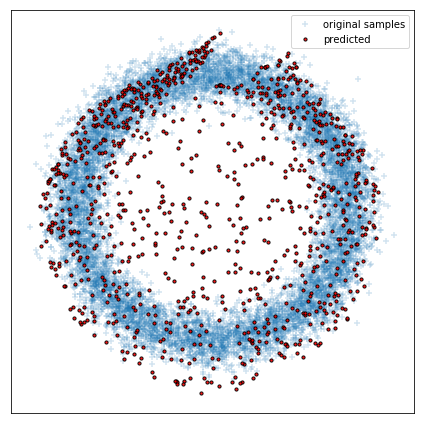

('Epoch: ', 150)


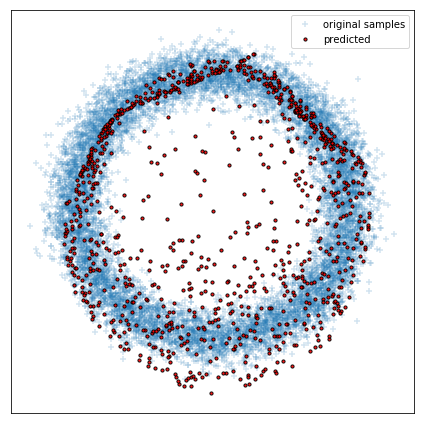

('Epoch: ', 200)


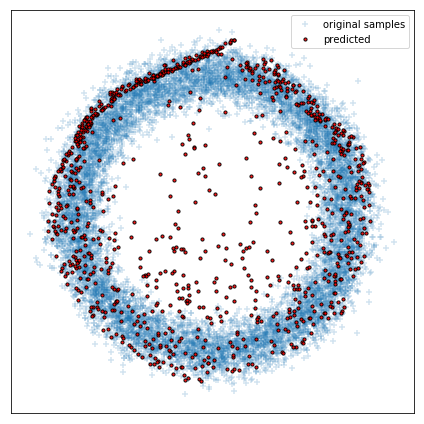

('Epoch: ', 250)


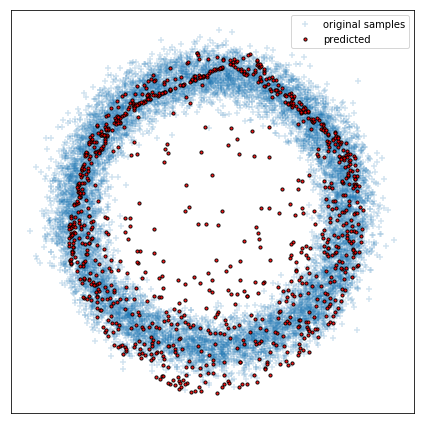

('Epoch: ', 300)


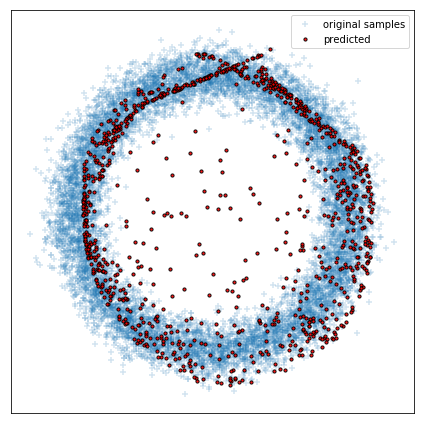

('Epoch: ', 350)


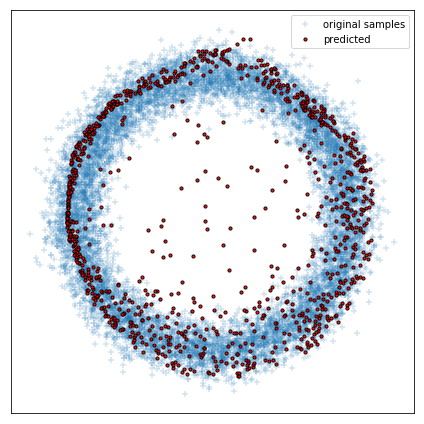

('Epoch: ', 400)


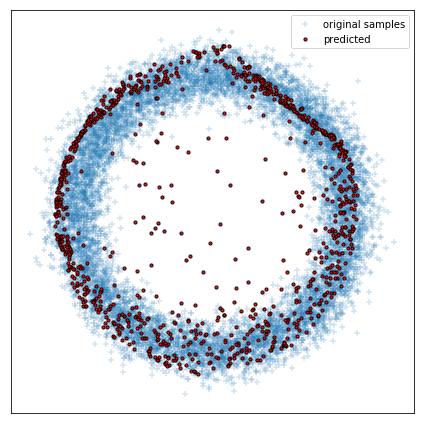

('Epoch: ', 450)


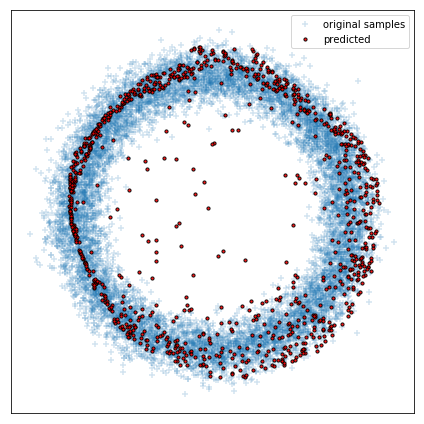

In [64]:
# we need now this dummy vector mandatory for the train on batch function (even though we do not need it)
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32)


for epoch in range(500):
    np.random.shuffle(X_train)

    minibatches_size = BATCH_SIZE * TRAINING_RATIO
    for i in range(int(X_train.shape[0] // (BATCH_SIZE * TRAINING_RATIO))):
        discriminator_minibatches = X_train[i * minibatches_size:(i + 1) * minibatches_size]
        for j in range(TRAINING_RATIO):
            sample_batch = discriminator_minibatches[j * BATCH_SIZE:(j + 1) * BATCH_SIZE]
            noise = # TO BE FILLED
            
            discriminator_model.train_on_batch(# TO BE FILLED)
        
        generator_model.train_on_batch(# TO BE FILLED)
        
    if epoch%50==0:
        print("Epoch: ", epoch)
        generate_images(generator, noise_dim)

Again, do not hesitate to play with the different parameters so that you get a better idea of the method sensibility.